In [49]:
import numpy as np
import time
import pickle
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras


In [52]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11530100090175154612
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11205746617233302722
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Dataset Setup

This notebook assumes that the datasets are already downloaded and placed locally.

Expected directory structure:

content

 ├── Humans/        # Human face images

 └── images/        # Anime face images

Datasets used:
- Human Faces Dataset: https://www.kaggle.com/datasets/ashwingupta3012/human-faces

- Anime Face Dataset: https://www.kaggle.com/datasets/splcher/animefacedataset


Due to licensing and credential constraints, datasets are not downloaded automatically.


In [53]:
tf.random.set_seed(8)

In [58]:
!find /content -maxdepth 2 -type d



/content
/content/.config
/content/.config/configurations
/content/.config/logs
/content/Humans
/content/images
/content/sample_data


In [60]:
HUMAN_PATH = "/content/Humans"
ANIME_PATH = "/content/images"

import os
assert os.path.exists(HUMAN_PATH), "Human dataset path not found"
assert os.path.exists(ANIME_PATH), "Anime dataset path not found"


In [61]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1
EPOCHS = 5      #Model trained for limited epochs due to compute constraints.


In [62]:
def preprocess_image(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1
    return image



In [63]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (img / 127.5) - 1   # Normalize to [-1, 1]
    return img


In [64]:
def make_dataset(folder):
    ds = tf.data.Dataset.list_files(folder + "/*", shuffle=True)

    ds = ds.map(
        lambda x: preprocess_image(
            tf.image.decode_image(
                tf.io.read_file(x),
                channels=3,
                expand_animations=False
            )
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [65]:
trainA_data = make_dataset(HUMAN_PATH)
trainB_data = make_dataset(ANIME_PATH)


In [66]:
human_ds = make_dataset(HUMAN_PATH)
anime_ds = make_dataset(ANIME_PATH)


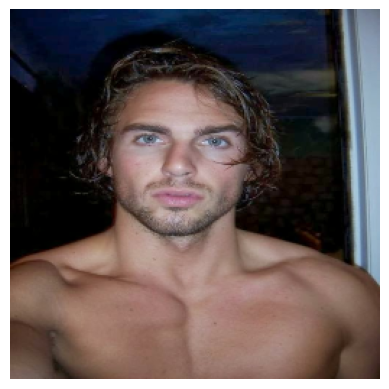

In [67]:
for img in trainA_data.take(1):
    plt.imshow((img[0] + 1) / 2)
    plt.axis("off")


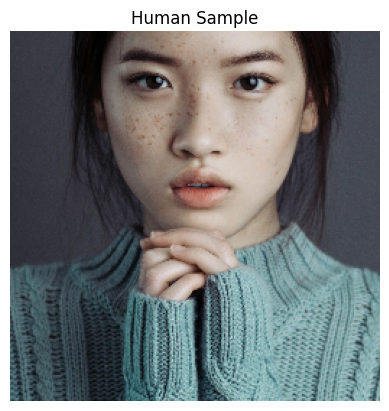

In [68]:
import matplotlib.pyplot as plt

for img in human_ds.take(1):
    plt.imshow((img[0] + 1) / 2)
    plt.title("Human Sample")
    plt.axis("off")


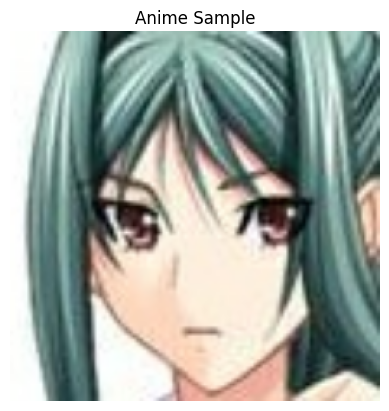

In [69]:
for img in anime_ds.take(1):
    plt.imshow((img[0] + 1) / 2)
    plt.title("Anime Sample")
    plt.axis("off")


In [70]:
def resize(image):
  image= tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image


def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def preprocess_image(image):
  image = resize(image)
  image = random_crop(image)
  image = random_jitter(image)
  return image

def random_jitter(image):
  if IMG_HEIGHT == 256:
    jitter = 286
  if IMG_HEIGHT == 128:
    jitter = 144

  image = tf.image.resize(image, [jitter],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  image = tf.image.random_flip_left_right(image)
  return image

In [71]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array


DATASET_DIR = "/content/images"
IMG_SIZE = (128, 128)
TRAIN_SIZE = 1000
TEST_SIZE = 100


all_images = [os.path.join(DATASET_DIR, f) for f in os.listdir(DATASET_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))]


trainB, testB = train_test_split(all_images, test_size=TEST_SIZE, train_size=TRAIN_SIZE, random_state=42)


def load_and_preprocess_images(image_paths, img_size):
    images = []
    for path in image_paths:

        img = load_img(path, target_size=img_size)
        img = img_to_array(img)
        img = (img / 256)
        images.append(img)
    return np.array(images)

trainB_data = load_and_preprocess_images(trainB, IMG_SIZE)
testB_data = load_and_preprocess_images(testB, IMG_SIZE)
np.save("trainB.npy", trainB_data)
np.save("testB.npy", testB_data)

print(f"Train data shape: {trainB_data.shape}")
print(f"Test data shape: {testB_data.shape}")


Train data shape: (1000, 128, 128, 3)
Test data shape: (100, 128, 128, 3)


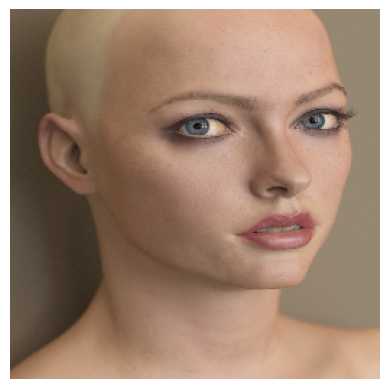

In [73]:
for img in trainA_data.take(1):
    plt.imshow((img[0] + 1) / 2)
    plt.axis("off")


In [74]:
sampleA = next(iter(trainA_data))
sampleB = next(iter(trainB_data))

In [75]:
# for img in trainA_data.take(1):
#     plt.imshow((img[0] + 1) / 2)
#     plt.axis("off")

In [76]:
def get_norm_layer(norm):
  if norm == 'instance_norm':
    return tfa.layers.InstanceNormalization
  elif norm == 'layer_norm':
    return keras.layers.LayerNormalization
weight_init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
initializer = weight_init

In [77]:
def Generator(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = get_norm_layer(norm)


    def _residual_block(x):
        dim = x.shape[-1]
        h = x
        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False, kernel_initializer=initializer)
        h = Norm()
        h = tf.nn.relu

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    h = inputs = keras.Input(shape=input_shape)
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False, kernel_initializer=initializer)(h)
    h = Norm()(h)
    h = tf.nn.relu(h)

    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    for _ in range(n_blocks):
        h = _residual_block(h)

    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(output_channels, 7, padding='valid', kernel_initializer=initializer)(h)
    h = tf.tanh(h)

    return keras.Model(inputs=inputs, outputs=h)

In [78]:
def Discriminator(input_shape=(256, 256, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm'):
    dim_ = dim
    Norm = _get_norm_layer(norm)

    h = inputs = keras.Input(shape=input_shape)

    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', kernel_initializer=initializer)(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer)(h)
        h = Norm()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)

    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False, kernel_initializer=initializer)(h)
    h = Norm()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(h)

    return keras.Model(inputs=inputs, outputs=h)

In [79]:

class ItemPool:

    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.items = []

    def __call__(self, in_items):

        if self.pool_size == 0:
            return in_items

        out_items = []
        for in_item in in_items:
            if len(self.items) < self.pool_size:
                self.items.append(in_item)
                out_items.append(in_item)
            else:
                if np.random.rand() > 0.5:
                    idx = np.random.randint(0, len(self.items))
                    out_item, self.items[idx] = self.items[idx], in_item
                    out_items.append(out_item)
                else:
                    out_items.append(in_item)
        return tf.stack(out_items, axis=0)

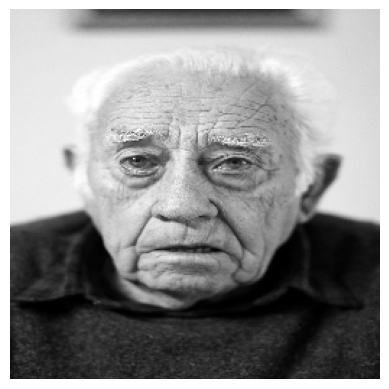

In [80]:
for img in trainA_data.take(1):
    plt.imshow((img[0] + 1) / 2)
    plt.axis("off")


## Future Work

- Train the CycleGAN model for more epochs to improve visual quality
- Experiment with higher resolution images (e.g., 256×256)
- Add quantitative evaluation metrics (FID / IS)
- Improve generator architecture and normalization strategy
- Package the training code into modular Python scripts
